*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,matplotlib,nltk,sklearn,tensorflow,theano,mxnet,chainer,seaborn,keras,tflearn,bokeh,gensim

/srv/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.
/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Gopala KR 
last updated: 2018-02-28 

CPython 3.6.3
IPython 6.2.1

watermark 1.6.0
numpy 1.14.1
matplotlib 2.1.2
nltk 3.2.5
sklearn 0.19.1
tensorflow 1.5.0
theano 1.0.1
mxnet 1.1.0
chainer 3.4.0
seaborn 0.8.1
keras 2.1.4
tflearn n
bokeh 0.12.14
gensim 3.3.0


/srv/venv/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Using TensorFlow's Dataset API

TensorFlow provides users with multiple options for providing data to the model. One of the probably most common methods is to define placeholders in the TensorFlow graph and feed the data from the current Python session into the TensorFlow `Session` using the `feed_dict` parameter. Using this approach, a large dataset that does not fit into memory is most conveniently and efficiently stored using NumPy archives as explained in [Chunking an Image Dataset for Minibatch Training using NumPy NPZ Archives](image-data-chunking-npz.ipynb) or HDF5 data base files ([Storing an Image Dataset for Minibatch Training using HDF5](image-data-chunking-hdf5.ipynb)).

Another approach, which is often preferred when it comes to computational efficiency, is to do the "data loading" directly in the graph using input queues from so-called TFRecords files, which is illustrated in the [Using Input Pipelines to Read Data from TFRecords Files](tfrecords.ipynb) notebook. 

Now, one could also use inpute input queues to load the data directly on the graph [Using Queue Runners to Feed Images Directly from Disk](file-queues.ipynb). The examples in this Jupyter notebook present an alternative to this manual approach, using TensorFlow's "new" Dataset API, which is described in more detail here: https://www.tensorflow.org/programmers_guide/datasets

## 0. The Dataset

Let's pretend we have a directory of images containing two subdirectories with images for training, validation, and testing. The following function will create such a dataset of images in JPEG format locally for demonstration purposes.

In [2]:
# Note that executing the following code 
# cell will download the MNIST dataset
# and save all the 60,000 images as separate JPEG
# files. This might take a few minutes depending
# on your machine.

import numpy as np
from helper import mnist_export_to_jpg

np.random.seed(123)
mnist_export_to_jpg(path='./')

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


The `mnist_export_to_jpg` function called above creates 3 directories, mnist_train, mnist_test, and mnist_validation. Note that the names of the subdirectories correspond directly to the class label of the images that are stored under it:

In [3]:
import os

for i in ('train', 'valid', 'test'): 
    dirs = [d for d in os.listdir('mnist_%s' % i) if not d.startswith('.')]
    print('mnist_%s subdirectories' % i, dirs)

mnist_train subdirectories ['6', '5', '2', '1', '7', '8', '4', '9', '3', '0']
mnist_valid subdirectories ['6', '5', '2', '1', '7', '8', '4', '9', '3', '0']
mnist_test subdirectories ['6', '5', '2', '1', '7', '8', '4', '9', '3', '0']


To make sure that the images look okay, the snippet below plots an example image from the subdirectory `mnist_train/9/`:

(28, 28)


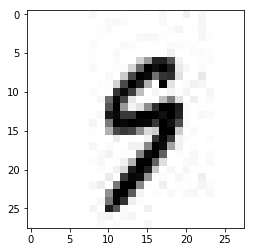

In [4]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

some_img = os.path.join('./mnist_train/9/', os.listdir('./mnist_train/9/')[0])

img = mpimg.imread(some_img)
print(img.shape)
plt.imshow(img, cmap='binary');

Note: The JPEG format introduces a few artifacts that we can see in the image above. In this case, we use JPEG instead of PNG. Here, JPEG is used for demonstration purposes since that's still format many image datasets are stored in.

## 1. TensorFlow Datasets

TensorFlow's new Dataset API introduces several new concepts, with the goal of feeding data to the computational graph more efficiently (compared to other approaches like the session's `feed_dicts` that insert values into the "placeholders" of a graph). In this context, a `Dataset` can be understood as a collection of "elements," where each element is composed of multiple tensors. In turn, each element might contain several objects of different types. 

But before we jump further into creating "datasets," let's generate Python lists of the image paths and image labels from the MNIST dataset that we prepared in the first section. 

Note that TensorFlow datasets can be shuffled, and we will use the `shuffle` operation later on, however, the shuffling operation only shuffles a subset of the whole dataset. The number of elements being shuffled is determined by the `buffer_size` parameter, which also determines how many elements are loaded into memory for shuffling. And since we typically cannot load all elements into memory, it is a good idea to shuffle our dataset, which might be organized by class labels, upfront.


In [5]:
import glob
import random

random.seed(123)

train_paths = glob.glob('mnist_train/**/*.jpg', recursive=True)
train_labels = [int(s.split('/')[1]) for s in train_paths]
tmp = list(zip(train_paths, train_labels))
random.shuffle(tmp)
train_paths, train_labels = zip(*tmp)

valid_paths = glob.glob('mnist_valid/**/*.jpg', recursive=True)
valid_labels = [int(s.split('/')[1]) for s in valid_paths]
tmp = list(zip(valid_paths, valid_labels))
random.shuffle(tmp)
valid_paths, valid_labels = zip(*tmp)

test_paths = glob.glob('mnist_test/**/*.jpg', recursive=True)
test_labels = [int(s.split('/')[1]) for s in test_paths]
tmp = list(zip(test_paths, test_labels))
random.shuffle(tmp)
test_paths, test_labels = zip(*tmp)

After creating Python lists storing the image paths and corresponding class labels, we can convert these to TensorFlow tensors and use the `Dataset`'s `from_tensor_slice` function to create dataset objects. Based on those `Dataset` objects, we can then create an `Iterator` object to fetch data examples form the "dataset;" the "fetching" operation is called `.get_next()`. Finally, we need initializers for the different datasets (train, validation, and test), if we want to use them in a TensorFlow session.

In [6]:
import tensorflow as tf


data_g1 = tf.Graph()

with data_g1.as_default():
    
    # setup tensor elements for the dataset
    tf_train_paths = tf.constant(train_paths)
    tf_train_labels = tf.constant(train_labels)
    tf_valid_paths = tf.constant(valid_paths)
    tf_valid_labels = tf.constant(valid_labels)
    tf_test_paths = tf.constant(test_paths)
    tf_test_labels = tf.constant(test_labels)
    
    
    # construct datasets from tf.Tensor objects
    train_dataset = tf.data.Dataset.from_tensor_slices((tf_train_paths,
                                                        tf_train_labels)) 
    valid_dataset = tf.data.Dataset.from_tensor_slices((tf_valid_paths,
                                                        tf_valid_labels)) 
    test_dataset = tf.data.Dataset.from_tensor_slices((tf_test_paths,
                                                       tf_test_labels)) 
    
    # initializing iterator to extract elements from the dataset
    #   Note: only need 1 iterator, since validation and test 
    #   datasets have the same image shapes
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
    
    # define op that fetches the next element from the iterator
    next_element = iterator.get_next()
    
    # define initializers for the iterator
    train_iter_init = iterator.make_initializer(train_dataset)
    valid_iter_init = iterator.make_initializer(valid_dataset)
    test_iter_init = iterator.make_initializer(test_dataset)

Now, after this quite elaborate setup, let us fetch data examples in a TensorFlow session to make sure that our setup works as intended:

In [7]:
with tf.Session(graph=data_g1) as sess:

    sess.run(train_iter_init)
    for i in range(3):
        print('Fetch element #%d from training dataset:' % (i+1))
        ele = sess.run(next_element)
        print(ele)
    
    print()
    sess.run(valid_iter_init)
    for i in range(3):
        print('Fetch element #%d from validation dataset:' % (i+1))
        ele = sess.run(next_element)
        print(ele)
        
    print()
    sess.run(test_iter_init)
    for i in range(3):
        print('Fetch element #%d from test dataset:' % (i+1))
        ele = sess.run(next_element)
        print(ele)

Fetch element #1 from training dataset:
(b'mnist_train/8/31749.jpg', 8)
Fetch element #2 from training dataset:
(b'mnist_train/1/25870.jpg', 1)
Fetch element #3 from training dataset:
(b'mnist_train/3/02099.jpg', 3)

Fetch element #1 from validation dataset:
(b'mnist_valid/6/45376.jpg', 6)
Fetch element #2 from validation dataset:
(b'mnist_valid/4/49419.jpg', 4)
Fetch element #3 from validation dataset:
(b'mnist_valid/9/45902.jpg', 9)

Fetch element #1 from test dataset:
(b'mnist_test/2/09055.jpg', 2)
Fetch element #2 from test dataset:
(b'mnist_test/0/01447.jpg', 0)
Fetch element #3 from test dataset:
(b'mnist_test/8/02945.jpg', 8)


As we can see, the procedure we defined only yields the file paths and class lables that we previously stored in Python lists. However, this is a good sanity check before we jump to the next step and read and prepare image files for machine learning or deep learning algorithms.

## 2. Preprocessing images

The `Dataset` API allows us to provide custom preprocessing functions that we can apply to our images. Since we are working with a relatively simple dataset such as MNIST, our preprocessing simply consists of reading in the image from a JPEG file, casting it to the correct type, normalizing the pixels to [0, 1] range, and perform a one-hot encoding on the labels:

In [8]:
def read_image_jpg_onehot(path, label):
    str_tensor = tf.read_file(path)
    decoded_image = tf.image.decode_jpeg(str_tensor,
                                         channels=1,
                                         fancy_upscaling=False)
    # normalize to [0, 1] range
    decoded_image = tf.cast(decoded_image, tf.float32)
    decoded_image = decoded_image / 255.
    # depth=10 because we have 10 mnist class labels
    onehot_label = tf.one_hot(label, depth=10)
    return decoded_image, onehot_label

In addition to using the `map` function (shown in the next code snippet), we will also shuffle the dataset and yield batches (instead of single training examples). For simplicity, we omit the test dataset, but its preparation is analogous to the validation dataset.

In [9]:
BATCH_SIZE = 128

def datareader():
    tf_train_paths = tf.constant(train_paths)
    tf_train_labels = tf.constant(train_labels)
    tf_valid_paths = tf.constant(valid_paths)
    tf_valid_labels = tf.constant(valid_labels)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((tf_train_paths,
                                                        tf_train_labels)) 
    valid_dataset = tf.data.Dataset.from_tensor_slices((tf_valid_paths,
                                                        tf_valid_labels)) 
    
    ############################################################
    ## Custom data transformation; 
    #  here: image reading, shuffling, batching
    train_dataset = train_dataset.map(read_image_jpg_onehot,
                                      num_parallel_calls=4)
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    
    valid_dataset = valid_dataset.map(read_image_jpg_onehot,
                                      num_parallel_calls=4)
    valid_dataset = valid_dataset.batch(BATCH_SIZE)
    ############################################################

    iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)

    next_element = iterator.get_next(name='next_element')
    
    train_iter_init = iterator.make_initializer(train_dataset,
                                                name='train_iter_init')
    valid_iter_init = iterator.make_initializer(valid_dataset,
                                                name='valid_iter_init')
    
    return next_element


data_g2 = tf.Graph()
with data_g2.as_default():
    datareader()

/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [10]:
with tf.Session(graph=data_g2) as sess:

    sess.run('train_iter_init')
    for i in range(3):
        print('Fetch batch #%d from training dataset:' % (i+1))
        images, labels = sess.run(['next_element:0', 'next_element:1'])
        print(images.shape, labels.shape)
        
    print()
    sess.run('valid_iter_init')
    for i in range(3):
        print('Fetch batch #%d from validation dataset:' % (i+1))
        images, labels = sess.run(['next_element:0', 'next_element:1'])
        print(images.shape, labels.shape)

Fetch batch #1 from training dataset:
(128, 28, 28, 1) (128, 10)
Fetch batch #2 from training dataset:
(128, 28, 28, 1) (128, 10)
Fetch batch #3 from training dataset:
(128, 28, 28, 1) (128, 10)

Fetch batch #1 from validation dataset:
(128, 28, 28, 1) (128, 10)
Fetch batch #2 from validation dataset:
(128, 28, 28, 1) (128, 10)
Fetch batch #3 from validation dataset:
(128, 28, 28, 1) (128, 10)


## 3. Using the Dataset API to train a neural network

The next code example illustrates how we can use the `Dataset` API to train a simple 2-layer multilayer perceptron. Note that we previously defined as `datareader()` function so that we can insert here instead of copy & pasting the code into the graph.

In [11]:
##########################
### SETTINGS
##########################

# Hyperparameters
learning_rate = 0.1
n_epochs = 15
n_iter = n_epochs * (len(train_paths) // BATCH_SIZE)

# Architecture
n_hidden_1 = 128
n_hidden_2 = 256
height, width = 28, 28
n_classes = 10



##########################
### GRAPH DEFINITION
##########################

g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(123)

    # Input data
    next_element = datareader()
    
    tf_images = tf.placeholder_with_default(next_element[0],
                                            shape=[None, 28, 28, 1], 
                                            name='images')
    tf_labels = tf.placeholder_with_default(next_element[1], 
                                            shape=[None, 10], 
                                            name='labels')
    
    tf_images = tf.reshape(tf_images, (tf.shape(tf_images)[0], 784))
    tf_images = tf.cast(tf_images, dtype=tf.float32)

    # Model parameters
    weights = {
        'h1': tf.Variable(tf.truncated_normal([height*width, n_hidden_1], stddev=0.1)),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.1)),
        'out': tf.Variable(tf.truncated_normal([n_hidden_2, n_classes], stddev=0.1))
    }
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'b2': tf.Variable(tf.zeros([n_hidden_2])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }

    # Multilayer perceptron
    layer_1 = tf.add(tf.matmul(tf_images, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']

    # Loss and optimizer
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=out_layer, labels=tf_labels)
    cost = tf.reduce_mean(loss, name='cost')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(cost, name='train')

    # Prediction
    prediction = tf.argmax(out_layer, 1, name='prediction')
    correct_prediction = tf.equal(tf.argmax(tf_labels, 1), tf.argmax(out_layer, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/srv/venv/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:539: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


Now, after defining the computational graph, the next code snippet will train the multilayer perceptron.

In [12]:
with tf.Session(graph=g) as sess:
    sess.run('train_iter_init')
    sess.run(tf.global_variables_initializer())
    saver0 = tf.train.Saver()
    
    avg_cost = 0.
    iter_per_epoch = n_iter // n_epochs
    epoch = 0

    for i in range(n_iter):
        
        _, cost = sess.run(['train', 'cost:0'])
        avg_cost += cost
        
        if not i % iter_per_epoch:
            epoch += 1
            avg_cost /= iter_per_epoch
            print("Epoch: %03d | AvgCost: %.3f" % (epoch, avg_cost))
            avg_cost = 0.
            sess.run('train_iter_init')
    
    saver0.save(sess, save_path='./mlp')

Epoch: 001 | AvgCost: 0.007
Epoch: 002 | AvgCost: 0.475
Epoch: 003 | AvgCost: 0.235
Epoch: 004 | AvgCost: 0.182
Epoch: 005 | AvgCost: 0.150
Epoch: 006 | AvgCost: 0.127
Epoch: 007 | AvgCost: 0.111
Epoch: 008 | AvgCost: 0.097
Epoch: 009 | AvgCost: 0.086
Epoch: 010 | AvgCost: 0.077
Epoch: 011 | AvgCost: 0.069
Epoch: 012 | AvgCost: 0.062
Epoch: 013 | AvgCost: 0.055
Epoch: 014 | AvgCost: 0.050
Epoch: 015 | AvgCost: 0.045


To demonstrate how we can feed new data points to the network that are not part of the training queue, let's use the test dataset and load the images into Python and pass it to the graph using a `feed_dict`:

In [ ]:
with tf.Session(graph=g) as sess:
    sess.run('train_iter_init')
    sess.run(tf.global_variables_initializer())
    saver0 = tf.train.Saver()
    
    avg_cost = 0.
    iter_per_epoch = n_iter // n_epochs
    epoch = 0

    for i in range(n_iter):
        
        _, cost = sess.run(['train', 'cost:0'])
        avg_cost += cost
        
        if not i % iter_per_epoch:
            epoch += 1
            avg_cost /= iter_per_epoch
            print("Epoch: %03d | AvgCost: %.3f" % (epoch, avg_cost))
            avg_cost = 0.
            sess.run('train_iter_init')
    
    saver0.save(sess, save_path='./mlp')

Epoch: 001 | AvgCost: 0.007
Epoch: 002 | AvgCost: 0.475
Epoch: 003 | AvgCost: 0.235
Epoch: 004 | AvgCost: 0.182
Epoch: 005 | AvgCost: 0.150
Epoch: 006 | AvgCost: 0.127
Epoch: 007 | AvgCost: 0.111
Epoch: 008 | AvgCost: 0.097
Epoch: 009 | AvgCost: 0.086
Epoch: 010 | AvgCost: 0.077
Epoch: 011 | AvgCost: 0.069
Epoch: 012 | AvgCost: 0.062
Epoch: 013 | AvgCost: 0.055


## 4. Feeding new datapoints through placeholders

To demonstrate how we can feed new data points to the network that are not part of the training queue, let's use the test dataset and load the images into Python and pass it to the graph using a `feed_dict`:

In [ ]:
import matplotlib.image as mpimg
import numpy as np
import glob


img_paths = np.array([p for p in glob.iglob('mnist_test/*/*.jpg')])
labels = np.array([int(path.split('/')[1]) for path in img_paths])


with tf.Session() as sess:
    
    saver1 = tf.train.import_meta_graph('./mlp.meta')
    saver1.restore(sess, save_path='./mlp')
    
    num_correct = 0
    cnt = 0
    for path, lab in zip(img_paths, labels):
        cnt += 1
        image = mpimg.imread(path)
        image = image.reshape(1, 28, 28, 1)
        
        pred = sess.run('prediction:0', 
                         feed_dict={'images:0': image})

        num_correct += int(lab == pred[0])
    acc = num_correct / cnt * 100

print('Test accuracy: %.1f%%' % acc)